In [1]:
import pandas as pd
df = pd.read_csv('acc_5min_xyz_g_rh.csv')
df["datetime"] = pd.to_datetime(df["time"], format='ISO8601')
print(df.head())

                          time      X      Y      Z   a_mag_g  mag_sumabs_g  \
0         2025-12-04T15:41:06Z  0.328 -0.914 -0.105  0.976732         1.347   
1  2025-12-04T15:41:06.033333Z  0.289 -0.941 -0.098  0.989245         1.328   
2  2025-12-04T15:41:06.066667Z  0.254 -0.980 -0.082  1.015697         1.316   
3     2025-12-04T15:41:06.100Z  0.203 -1.074 -0.070  1.095256         1.347   
4  2025-12-04T15:41:06.133333Z  0.223 -0.988 -0.043  1.013766         1.254   

                          datetime  
0        2025-12-04 15:41:06+00:00  
1 2025-12-04 15:41:06.033333+00:00  
2 2025-12-04 15:41:06.066667+00:00  
3 2025-12-04 15:41:06.100000+00:00  
4 2025-12-04 15:41:06.133333+00:00  


In [2]:
# RPE data with date + time
rpe_data = {
    "datetime": [
        "2025-12-04 15:41:00",
        "2025-12-04 15:42:00",
        "2025-12-04 15:43:00",
        "2025-12-04 15:44:00",
        "2025-12-04 15:45:00",
        "2025-12-04 15:46:00",
    ],
    "rpe": [2, 4, 6, 7, 9, 10]
}

rpe_df = pd.DataFrame(rpe_data)
rpe_df["datetime"] = pd.to_datetime(rpe_df["datetime"], format='ISO8601')
rpe_df["datetime"] = pd.to_datetime(rpe_df["datetime"], utc=True)
rpe_series = (
    rpe_df.set_index("datetime")["rpe"]
          .sort_index()
)

# 1-second timeline covering the RPE range
sec_index = pd.date_range(
    start=rpe_series.index.min(),
    end=rpe_series.index.max(),
    freq="1S",
    tz="UTC"
)

# Reindex + time interpolation -> per-second RPE curve
rpe_1s = (
    rpe_series.reindex(sec_index)
              .interpolate(method="time")
              .rename("rpe_interp")
              .to_frame()
              .reset_index()
              .rename(columns={"index": "datetime"})
)

rpe_1s.head(), rpe_1s.tail()

/tmp/ipykernel_21631/692455997.py:23: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  sec_index = pd.date_range(


(                   datetime  rpe_interp
 0 2025-12-04 15:41:00+00:00    2.000000
 1 2025-12-04 15:41:01+00:00    2.033333
 2 2025-12-04 15:41:02+00:00    2.066667
 3 2025-12-04 15:41:03+00:00    2.100000
 4 2025-12-04 15:41:04+00:00    2.133333,
                      datetime  rpe_interp
 296 2025-12-04 15:45:56+00:00    9.933333
 297 2025-12-04 15:45:57+00:00    9.950000
 298 2025-12-04 15:45:58+00:00    9.966667
 299 2025-12-04 15:45:59+00:00    9.983333
 300 2025-12-04 15:46:00+00:00   10.000000)

In [3]:
# df columns: datetime (UTC-aware), a_mag_g
df = df.sort_values("datetime").copy()
df["sec"] = df["datetime"].dt.floor("S")

acc_1s = (
    df.groupby("sec")["a_mag_g"]
      .agg(
          peak_acc="max",
          rms_acc=lambda x: (x**2).mean()**0.5,
          std_acc="std",
          p95_acc=lambda x: x.quantile(0.95),
      )
      .reset_index()
      .rename(columns={"sec": "datetime"})
)

acc_1s.head()


/tmp/ipykernel_21631/1291891428.py:3: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df["sec"] = df["datetime"].dt.floor("S")


,datetime,peak_acc,rms_acc,std_acc,p95_acc
0,2025-12-04 15:41:06+00:00,1.592799,1.109425,0.158783,1.392701
1,2025-12-04 15:41:07+00:00,3.645322,1.816533,0.820277,3.110689
2,2025-12-04 15:41:08+00:00,3.777493,1.821051,0.705820,3.095254
3,2025-12-04 15:41:09+00:00,3.413735,1.973303,0.980189,3.218833
4,2025-12-04 15:41:10+00:00,3.419743,1.799063,0.757416,3.039780


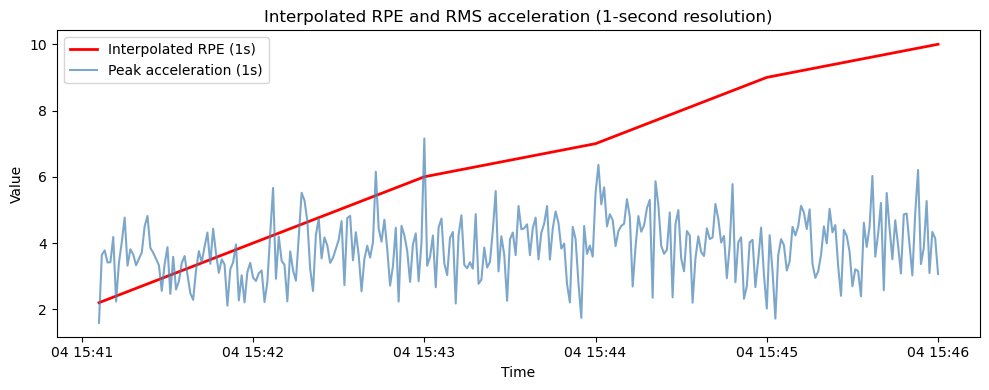

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.plot(
    exp_df["datetime"],
    exp_df["rpe_interp"],
    label="Interpolated RPE (1s)",
    color="red",
    linewidth=2
)

plt.plot(
    exp_df["datetime"],
    exp_df["peak_acc"],
    label="Peak acceleration (1s)",
    color="steelblue",
    alpha=0.7
)

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Interpolated RPE and RMS acceleration (1-second resolution)")
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
exp_df = pd.merge(rpe_1s, acc_1s, on="datetime", how="inner")
exp_df = exp_df.dropna()

print(exp_df.shape)
exp_df[["datetime", "rpe_interp", "peak_acc"]].head()


(295, 6)


,datetime,rpe_interp,peak_acc
0,2025-12-04 15:41:06+00:00,2.200000,1.592799
1,2025-12-04 15:41:07+00:00,2.233333,3.645322
2,2025-12-04 15:41:08+00:00,2.266667,3.777493
3,2025-12-04 15:41:09+00:00,2.300000,3.413735
4,2025-12-04 15:41:10+00:00,2.333333,3.419743


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

X = exp_df[["peak_acc"]]
y = exp_df["rpe_interp"]

m = LinearRegression().fit(X, y)
pred = m.predict(X)

print("R2:", r2_score(y, pred))
print("MAE:", mean_absolute_error(y, pred))
print("coef:", m.coef_, "intercept:", m.intercept_)


R2: 0.047650890934377244
MAE: 1.8508720284340643
coef: [0.54417148] intercept: 4.392831572933464


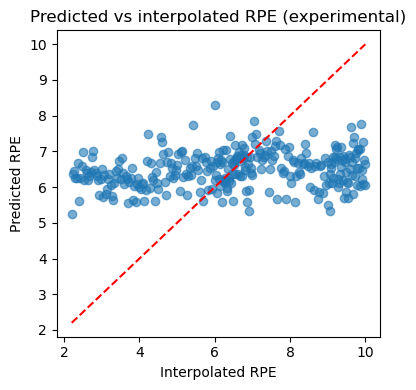

In [15]:
plt.figure(figsize=(4, 4))

plt.scatter(exp_df["rpe_interp"], pred, alpha=0.6)
plt.plot(
    [exp_df["rpe_interp"].min(), exp_df["rpe_interp"].max()],
    [exp_df["rpe_interp"].min(), exp_df["rpe_interp"].max()],
    "r--"
)

plt.xlabel("Interpolated RPE")
plt.ylabel("Predicted RPE")
plt.title("Predicted vs interpolated RPE (experimental)")
plt.tight_layout()
plt.show()


In [21]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

X = exp_df[["peak_acc"]]
y = exp_df["rpe_interp"]

loo = LeaveOneOut()

y_true = []
y_pred = []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    tree = DecisionTreeRegressor(
        max_depth=4,          
        min_samples_leaf=2,   
        random_state=0
    )

    tree.fit(X_train, y_train)
    y_pred.append(tree.predict(X_test)[0])
    y_true.append(y_test.values[0])


In [22]:
print("MAE:", mean_absolute_error(y_true, y_pred))
print("R2:", r2_score(y_true, y_pred))


MAE: 1.9850710182432145
R2: -0.08833689345518603


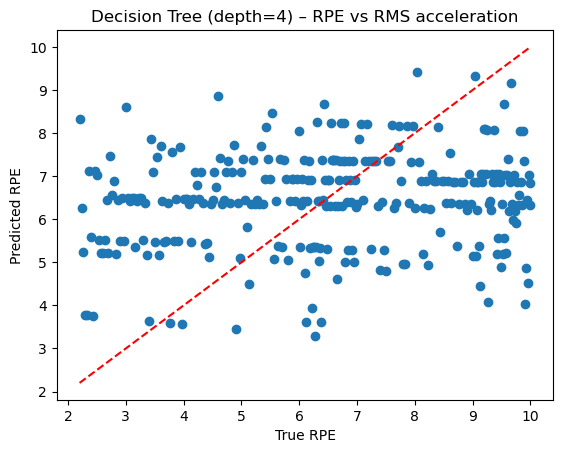

In [24]:
import matplotlib.pyplot as plt

plt.scatter(y_true, y_pred)
plt.plot([min(y), max(y)], [min(y), max(y)], "r--")
plt.xlabel("True RPE")
plt.ylabel("Predicted RPE")
plt.title("Decision Tree (depth=4) – RPE vs RMS acceleration")
plt.show()


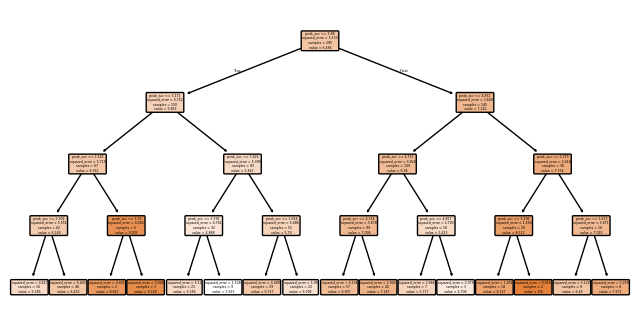

In [25]:
from sklearn.tree import plot_tree

tree.fit(X, y)

plt.figure(figsize=(8, 4))
plot_tree(
    tree,
    feature_names=["peak_acc"],
    filled=True,
    rounded=True
)
plt.show()


In [29]:
from scipy.stats import pearsonr
r, p = pearsonr(exp_df["peak_acc"], exp_df["rpe_interp"])
print(r)

0.21829084024387535
